In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
path = "../data"
# Read the experimental data (cross-sectional)
lalonde_exp = pd.read_csv(f"{path}/lalonde_exp.csv")

# Read the observational data from PSID (cross-sectional)
lalonde_psid = pd.read_csv(f"{path}/lalonde_psid.csv")
lalonde_psid.insert(1, "y", lalonde_psid["re78"] - lalonde_psid["re75"])


Categorical variables: Race (Black, Hispanic), 


/tmp/ipykernel_2019185/442550217.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  white = lalonde_psid[lalonde_psid["black"] == 0][lalonde_psid["hispanic"] == 0]


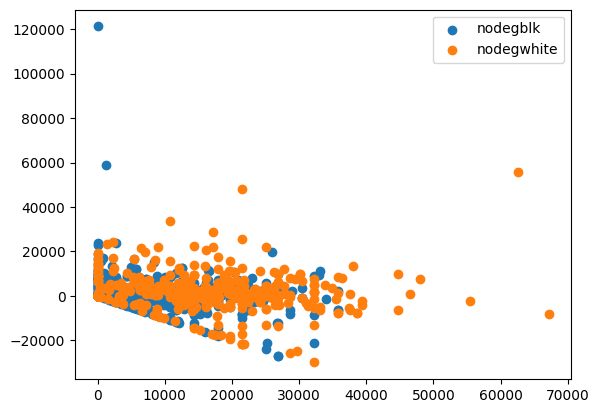

In [34]:
black = lalonde_psid[lalonde_psid["black"] == 1]
hisp = lalonde_psid[lalonde_psid["hispanic"] == 1]
white = lalonde_psid[lalonde_psid["black"] == 0][lalonde_psid["hispanic"] == 0]
plt.scatter(black[black["nodegree"] == 1]["re75"], black["y"][black["nodegree"] == 1], label="nodegblk")
plt.scatter(white[white["nodegree"] == 1]["re75"], white["y"][white["nodegree"] == 1], label="nodegwhite")
plt.legend()
plt.show()
# plt.scatter(lalonde_psid[lalonde_psid["nodegree"] == 0]["age"], lalonde_psid["y"][lalonde_psid["nodegree"] == 0], label="deg")

# plt.scatter(hisp["re75"], hisp["re78"], label="hisp")
# plt.scatter(white["re75"], white["re78"], label="white")

# lalonde_psid[lalonde_psid["black"] == 1].describe()

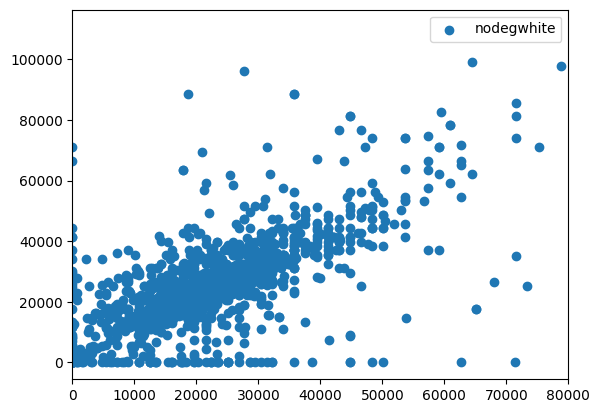

In [46]:
plt.scatter(white[white["nodegree"] ==0]["re75"], white["re78"][white["nodegree"] == 0], label="nodegwhite")
plt.xlim(0,80000)

plt.legend()
plt.show()

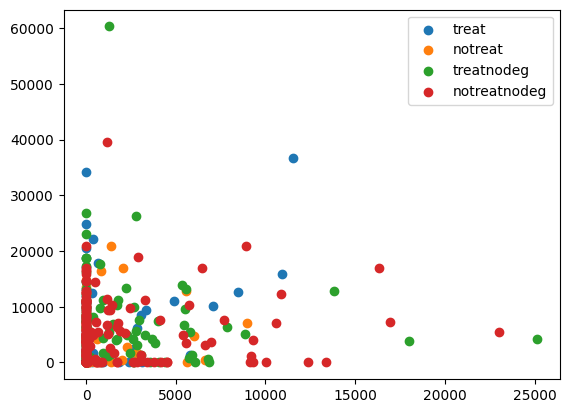

In [58]:
df = lalonde_exp[lalonde_exp["nodegree"] == 0]
plt.scatter(df["re75"][df["treat"] == 1], df[df["treat"] == 1]["re78"], label="treat")
plt.scatter(df["re75"][df["treat"] == 0], df[df["treat"] == 0]["re78"], label="notreat")

df1 = lalonde_exp[lalonde_exp["nodegree"] == 1]
plt.scatter(df1["re75"][df1["treat"] == 1], df1[df1["treat"] == 1]["re78"], label="treatnodeg")
plt.scatter(df1["re75"][df1["treat"] == 0], df1[df1["treat"] == 0]["re78"], label="notreatnodeg")
plt.legend()
plt.show()

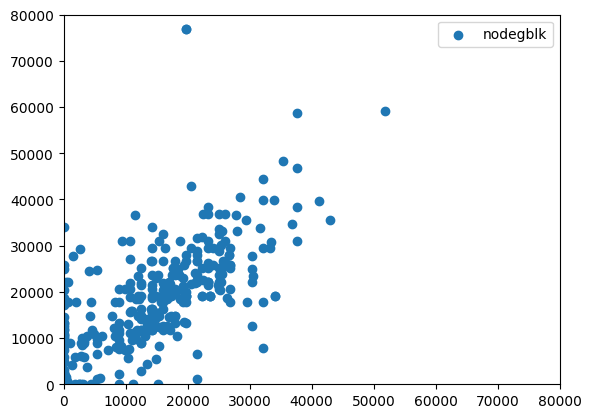

In [48]:
plt.scatter(black[black["nodegree"] ==0]["re75"], black["re78"][black["nodegree"] == 0], label="nodegblk")
plt.xlim(0,80000)
plt.ylim(0,80000)
plt.legend()
plt.show()


In [62]:
lalonde_exp.insert(1, "y", lalonde_exp["re78"] - lalonde_exp["re75"])


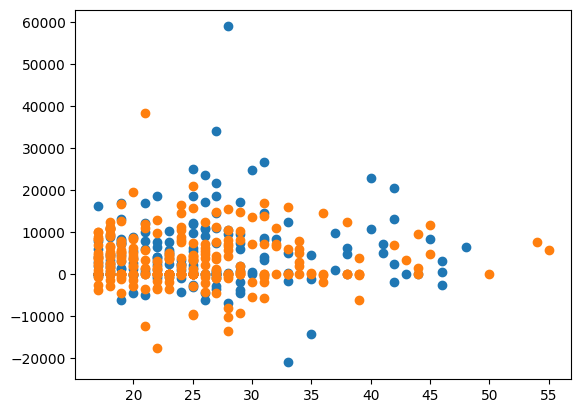

In [64]:
plt.scatter(lalonde_exp["age"][lalonde_exp["treat"] == 1], lalonde_exp[lalonde_exp["treat"] == 1]["y"] )
plt.scatter(lalonde_exp["age"][lalonde_exp["treat"] == 0], lalonde_exp[lalonde_exp["treat"] == 0]["y"] )

In [194]:
import numpy as np
import pandas as pd

def diff(df):
    treated = df[df["treat"] == 1]
    untreat = df[df["treat"] == 0]
    return (treated["re78"] - treated["re75"]).mean() - (untreat["re78"] - untreat["re75"]).mean()

def marriage_prob(x):
    return 0.9 * (1 - np.exp(-0.18 * (x - 16)))

# Define function to calculate means and covariances for each group
def compute_group_stats(df, group_vars, re_vars):
    group_stats = {}
    grouped = df.groupby(group_vars)
    for group, data in grouped:
        means = data[re_vars].mean().values
        cov = data[re_vars].cov().values
        group_stats[group] = (means, cov)
    return group_stats

re_vars = ["age", "re74", "re75", "re78"]
group_vars = ["black", "hispanic", "married", "nodegree"]
group_stats = compute_group_stats(lalonde_psid, group_vars, re_vars)

# Calculate probabilities for mutually exclusive race categories
proportions = lalonde_psid[["black", "hispanic", "married", "nodegree"]].mean()
prob_black = proportions["black"]
prob_hispanic = proportions["hispanic"]
prob_white = 1 - prob_black - prob_hispanic

# Calculate the probability of nodegree for each ethnicity
prob_nodegree_black = lalonde_psid[lalonde_psid["black"] == 1]["nodegree"].mean()
prob_nodegree_hispanic = lalonde_psid[lalonde_psid["hispanic"] == 1]["nodegree"].mean()
prob_nodegree_white = lalonde_psid[(lalonde_psid["black"] == 0) & (lalonde_psid["hispanic"] == 0)]["nodegree"].mean()

# Step 2: Compute ATE for each group in the experimental dataset
def compute_ate(df, group_vars):
    print(group_vars)
    ate_stats = {}
    grouped = df.groupby(group_vars)
    meanEffect = diff(df)
    for group, data in grouped:
        print("group size:", len(data))
        treat_effect = diff(data)
        ate_stats[group] = treat_effect
        print([group_vars[i] for i in range(len(group_vars)) if group[i] == 1], "Effect:", treat_effect)
        if len(data) < 10:
            ate_stats[group] = meanEffect

    return ate_stats

ate_stats = compute_ate(lalonde_exp, group_vars)

# Step 3: Generate Synthetic Data
def generate_synthetic_data(n, prob_black, prob_hispanic, prob_white, prob_nodegree_black, prob_nodegree_hispanic, prob_nodegree_white, group_stats, ate_stats):
    data = []

    while len(data) < n:
        # Generate ethnicity
        ethnicity = np.random.choice(['black', 'hispanic', 'white'], p=[prob_black, prob_hispanic, prob_white])
        
        black = int(ethnicity == 'black')
        hispanic = int(ethnicity == 'hispanic')
        
        # Generate nodegree based on ethnicity
        if black:
            nodegree = np.random.binomial(1, prob_nodegree_black)
        elif hispanic:
            nodegree = np.random.binomial(1, prob_nodegree_hispanic)
        else:
            nodegree = np.random.binomial(1, prob_nodegree_white)
        
        treat = np.random.binomial(1, 0.5)
        
        # Generate multivariate normal data
        group = (black, hispanic, 0, nodegree)
        means, cov = group_stats[group]
        sample = np.random.multivariate_normal(means, cov)
        
        age = sample[0].round().astype(int)
        
        if age < 16:
            continue
        
        # Generate married based on age using the fitted saturating exponential function
        p_married = marriage_prob(age)
        married = np.random.binomial(1, p_married)
        
        re74, re75, re78 = np.clip(sample[1:], 0, None)
        
        # Adjust re78 with the treatment effect if treated
        if treat == 1:
            treat_effect = ate_stats[(black, hispanic, married, nodegree)]
            re78 += treat_effect
        
        # Append valid data
        data.append([black, hispanic, married, nodegree, treat, age, re74, re75, re78])
    
    # Create DataFrame from valid data
    synthetic_data = pd.DataFrame(data, columns=["black", "hispanic", "married", "nodegree", "treat", "age", "re74", "re75", "re78"])
    
    return synthetic_data

n_samples = len(lalonde_exp)
synthetic_data = generate_synthetic_data(10000, prob_black, prob_hispanic, prob_white, prob_nodegree_black, prob_nodegree_hispanic, prob_nodegree_white, group_stats, ate_stats)

print("Diff: ", diff(synthetic_data))
synthetic_data.describe()


['black', 'hispanic', 'married', 'nodegree']
group size: 13
[] Effect: -3956.153761904764
group size: 18
['nodegree'] Effect: 3366.286100000001
group size: 2
['married'] Effect: nan
group size: 2
['married', 'nodegree'] Effect: 20102.36
group size: 2
['hispanic'] Effect: 1324.503
group size: 30
['hispanic', 'nodegree'] Effect: 983.980804347826
group size: 2
['hispanic', 'married'] Effect: -3698.2200000000003
group size: 5
['hispanic', 'married', 'nodegree'] Effect: -1696.1033333333335
group size: 63
['black'] Effect: 4214.725487525988
group size: 244
['black', 'nodegree'] Effect: 319.4007028860033
group size: 15
['black', 'married'] Effect: 4872.458833333334
group size: 49
['black', 'married', 'nodegree'] Effect: 3071.5093319397997
Diff:  1517.5012008610515


,black,hispanic,married,nodegree,treat,age,re74,re75,re78
count,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,0.283400,0.031900,0.738000,0.31830,0.496300,29.97270,13346.197223,13324.195466,17326.697119
std,0.450671,0.175743,0.439745,0.46584,0.500011,8.23446,10528.653184,10735.541915,12428.964303
min,0.000000,0.000000,0.000000,0.00000,0.000000,16.00000,0.000000,0.000000,-3956.153762
25%,0.000000,0.000000,0.000000,0.00000,0.000000,24.00000,4819.063904,4391.470264,7498.422181
50%,0.000000,0.000000,1.000000,0.00000,0.000000,29.00000,11873.359953,11632.248761,16001.819058
75%,1.000000,0.000000,1.000000,1.00000,1.000000,35.00000,19992.047006,20361.912939,25228.279616
max,1.000000,1.000000,1.000000,1.00000,1.000000,79.00000,59766.304259,62016.151057,66919.462938


In [192]:
lalonde_psid.to_csv("lalonde_psid.csv", index=False)

In [198]:
diff(synthetic_data[synthetic_data["married"] == 1][synthetic_data["black"] == 1][synthetic_data["hispanic"] == 0][synthetic_data["nodegree"] == 1])

/tmp/ipykernel_2019185/3940490212.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  diff(synthetic_data[synthetic_data["married"] == 1][synthetic_data["black"] == 1][synthetic_data["hispanic"] == 0][synthetic_data["nodegree"] == 1])
/tmp/ipykernel_2019185/3940490212.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  diff(synthetic_data[synthetic_data["married"] == 1][synthetic_data["black"] == 1][synthetic_data["hispanic"] == 0][synthetic_data["nodegree"] == 1])
/tmp/ipykernel_2019185/3940490212.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  diff(synthetic_data[synthetic_data["married"] == 1][synthetic_data["black"] == 1][synthetic_data["hispanic"] == 0][synthetic_data["nodegree"] == 1])


2944.825352080589

In [189]:
lalonde_psid[lalonde_psid["black"] == 0][lalonde_psid["hispanic"] == 0][lalonde_psid["married"] == 1][lalonde_psid["nodegree"] == 1]

/tmp/ipykernel_2019185/647035758.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lalonde_psid[lalonde_psid["black"] == 0][lalonde_psid["hispanic"] == 0][lalonde_psid["married"] == 1][lalonde_psid["nodegree"] == 1]
/tmp/ipykernel_2019185/647035758.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lalonde_psid[lalonde_psid["black"] == 0][lalonde_psid["hispanic"] == 0][lalonde_psid["married"] == 1][lalonde_psid["nodegree"] == 1]
/tmp/ipykernel_2019185/647035758.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lalonde_psid[lalonde_psid["black"] == 0][lalonde_psid["hispanic"] == 0][lalonde_psid["married"] == 1][lalonde_psid["nodegree"] == 1]


,age,y,education,black,hispanic,married,nodegree,re74,re75,re78,u74,u75,treat,id
136,23,2519.160000,8,0,0,1,1,0.000000,1713.150000,4232.310000,1,0,1,137
1923,53,0.000000,6,0,0,1,1,0.000000,0.000000,0.000000,1,1,0,1739
1929,55,0.000000,8,0,0,1,1,0.000000,0.000000,0.000000,1,1,0,1745
1931,41,0.000000,8,0,0,1,1,0.000000,0.000000,0.000000,1,1,0,1747
1932,45,0.000000,8,0,0,1,1,0.000000,0.000000,0.000000,1,1,0,1748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2669,32,-2443.933594,10,0,0,1,1,43103.871094,39387.097656,36943.164062,0,0,0,2485
2670,47,4731.566406,8,0,0,1,1,44667.363281,33837.097656,38568.664062,0,0,0,2486
2671,32,-8028.031250,8,0,0,1,1,47022.402344,67137.093750,59109.062500,0,0,0,2487
2672,47,7742.179688,10,0,0,1,1,48197.964844,47968.113281,55710.292969,0,0,0,2488


In [ ]:
synthetic_data[synthetic_data["black"] == 0][synthetic_data["hispanic"] == 0][synthetic_data["married"] == 1][synthetic_data["nodegree"] == 1]

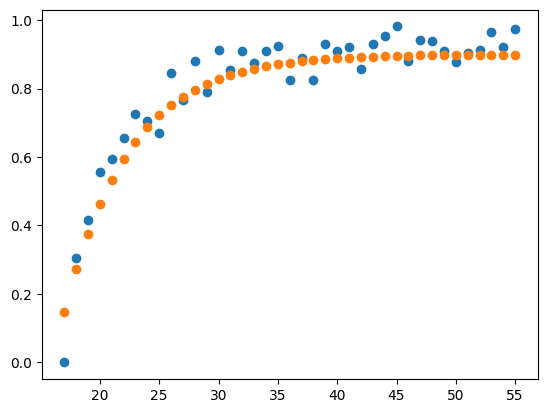

In [130]:
adf = lalonde_psid.groupby("age")[["married"]].mean().reset_index()
plt.scatter(adf["age"], adf["married"])
plt.scatter(adf["age"], marriage_prob(adf["age"]))
plt.show()

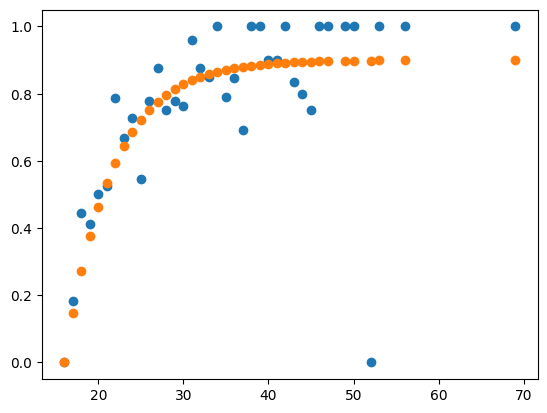

In [180]:
adf = synthetic_data.groupby("age")[["married"]].mean().reset_index()
plt.scatter(adf["age"], adf["married"])
plt.scatter(adf["age"], marriage_prob(adf["age"]))
plt.show()

In [179]:
lalonde_psid[["black", "hispanic", "married", "nodegree", "treat", "age", "re74", "re75", "re78"]].describe()

,black,hispanic,married,nodegree,treat,age,re74,re75,re78
count,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000,2675.000000
mean,0.291589,0.034393,0.819439,0.333084,0.069159,34.225794,18230.003082,17850.893864,20502.375698
std,0.454579,0.182269,0.384726,0.471404,0.253772,10.499842,13722.251599,13877.777230,15632.519644
min,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,25.000000,8816.700195,7605.290283,9243.401836
50%,0.000000,0.000000,1.000000,0.000000,0.000000,32.000000,17437.474609,17008.064453,19432.103516
75%,1.000000,0.000000,1.000000,1.000000,0.000000,43.500000,25470.468750,25583.709961,28815.667969
max,1.000000,1.000000,1.000000,1.000000,1.000000,55.000000,137148.687500,156653.234375,121173.578125
